### Import libraries

In [1]:
import torch
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, lr_scheduler, Adam
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import models
import operator
from tqdm import tqdm
import copy
from copy import deepcopy
import numpy as np
from sklearn.metrics import roc_auc_score
from time import time
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import datasets, transforms
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd

### Implementation of early stopping technique

In [2]:
class EarlyStopping():
    """
    This class represents early stopping technique
    """

    def __init__(self, tolerance=5, min_delta=0, mode='min'):
        """
        :param tolerance: the maximum number of times without improvements 
        :param min_delta: the smallest amount of improvement
        :param mode: minimize or maximize
        """
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.early_stop = False
        self.prev_metric = np.inf if mode == 'min' else -np.inf
        self.operation = operator.gt if mode == 'min' else operator.lt

    def __call__(self, metric) -> bool:
        delta = (metric - self.prev_metric)

        if self.operation(delta, self.min_delta):
            self.counter += 1
        else:
            self.counter = 0
            self.prev_metric = metric

        if self.counter >= self.tolerance:
            self.early_stop = True
        return self.early_stop

## Task 1. Baseline model [0pt]

### Download baseline model from 2 task

In [7]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)
        )
        # Second convolutional layer with residual connection
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )
        # Third convolutional layer with residual connection
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )
        # Fourth convolutional layer with residual connection
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2)
        )
        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 2 * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


baselinde_model = torch.load('RomanMakeev.pth')

## Task 2. Self-supervised learning [12pts]

### Load the data

In [8]:
dataset_path = 'cifar10'
BATCH_SIZE = 256

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root=dataset_path,
                                 train=True,
                                 transform=train_transforms,
                                 download=True)

train_loader = data.DataLoader(train_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=True,
                               drop_last=True,
                               num_workers=2)

test_dataset = datasets.CIFAR10(root=dataset_path,
                                train=False,
                                transform=test_transforms,
                                download=True)

test_loader = data.DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Make dataloader with 10 percent of train dataset

In [9]:
labels = train_dataset.targets
indices = list(range(len(labels)))
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.1, random_state=42)
train_indices, _ = next(sss.split(indices, labels))
sampled_train_sampler = SubsetRandomSampler(train_indices)

# dataloader with 10% of train dataset
train_loader_10_percent = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampled_train_sampler)

### Adding Noise
Since we have a small training dataset let's add gaussian to 50% of images and add salt and papper noise to the other 50% of images in the datased

In [10]:
# Define a function to add Gaussian noise to images
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = torch.randn_like(image) * std + mean
    noisy_image = image + noise
    return noisy_image

# Define a function to add Gaussian noise to images
def add_salt_and_pepper_noise(image, salt_vs_pepper=0.5, amount=0.04):
    noisy_image = image.clone()
    salt_mask = torch.rand_like(image) < amount * salt_vs_pepper
    pepper_mask = torch.rand_like(image) < amount * (1 - salt_vs_pepper)
    noisy_image[salt_mask] = 1.0
    noisy_image[pepper_mask] = 0.0
    return noisy_image

class NoisyImageDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get original image and label from the dataset
        image, label = self.dataset[idx]

        # Apply noise to the image: 50% - gaussian noise, 50% - salt and pepper noise
        noise_func = random.choice([add_gaussian_noise, add_salt_and_pepper_noise])
        noisy_image = noise_func(image)
        
        return noisy_image, image, label

In [11]:
# Loader with noisy images
train_loader_noisy = DataLoader(
    NoisyImageDataset(train_dataset),
    batch_size=BATCH_SIZE,
)

# Loader with 10% of test dataset with noise
train_loader_noisy_10 = DataLoader(
    NoisyImageDataset(train_dataset),
    batch_size=BATCH_SIZE,
    sampler=sampled_train_sampler
)

# test dataset with noise
test_loader_noisy = DataLoader(
    NoisyImageDataset(test_dataset),
    batch_size=BATCH_SIZE
)

Let's compare images with and without noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

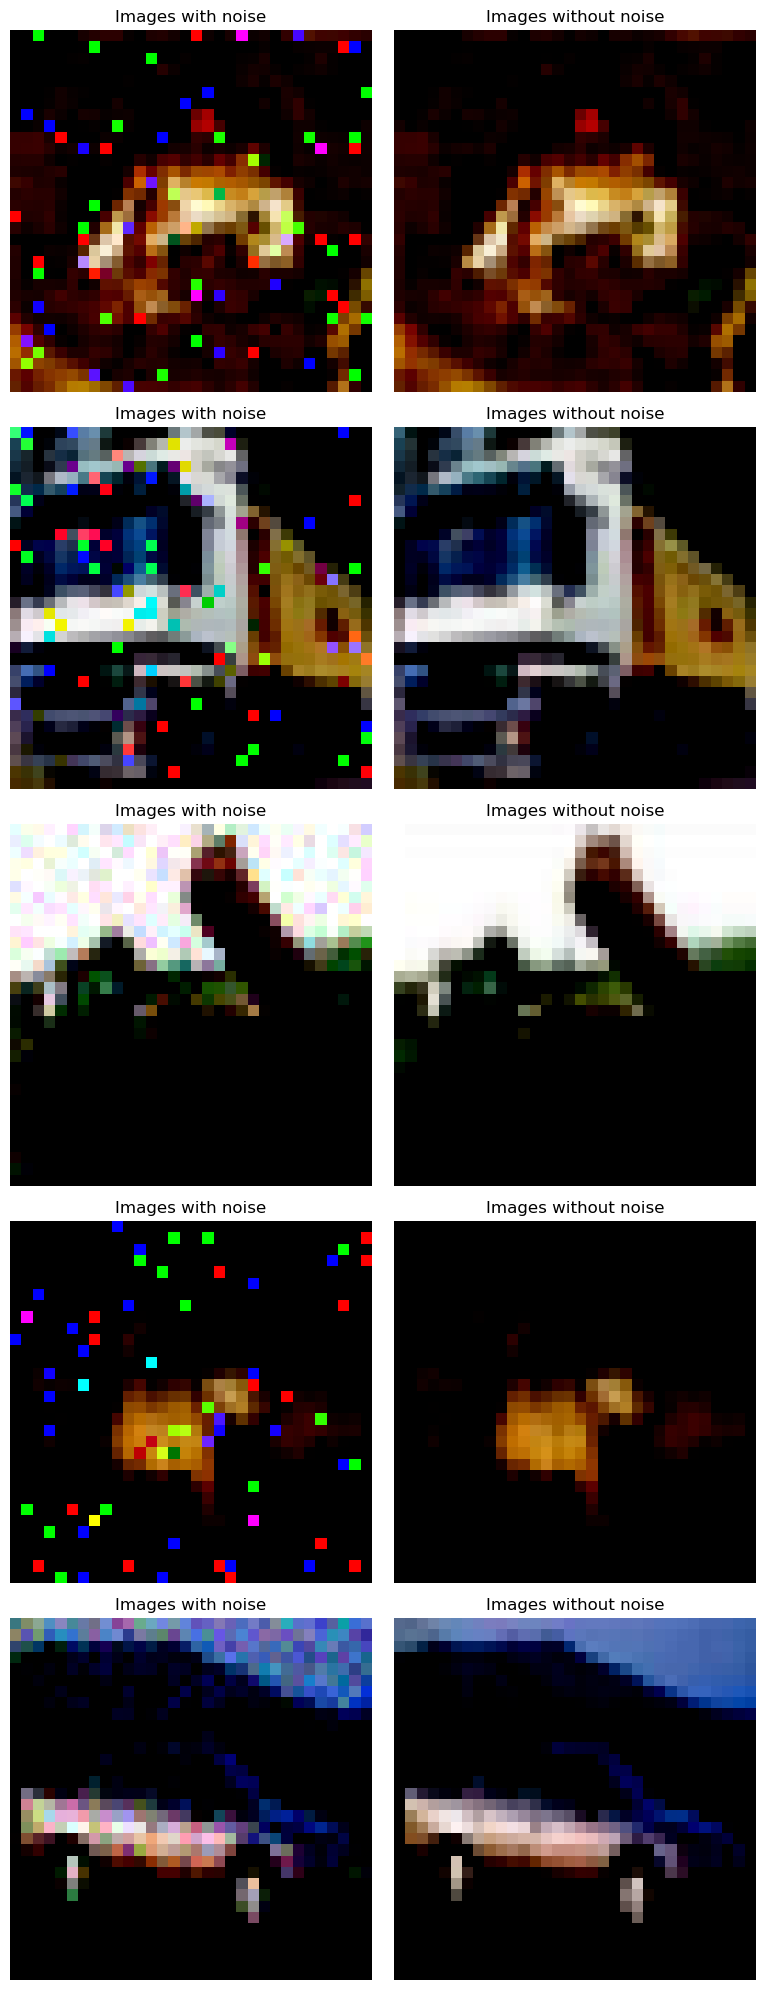

In [12]:
# This function plots images side by side
def plot_side_by_side(images, outputs, num_images=5, column1_name='Original', column2_name='Output'):
    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(8, 4 * num_images))

    for idx in range(num_images):
        # Plot original image
        ax = axes[idx, 0]
        ax.axis('off')
        ax.set_title(column1_name)
        ax.imshow(images[idx].permute(1, 2, 0))

        # Plot output of autoencoder
        ax = axes[idx, 1]
        ax.axis('off')
        ax.set_title(column2_name)
        ax.imshow(outputs[idx].permute(1, 2, 0))

    plt.tight_layout()
    plt.show()

dataiter = iter(train_loader_noisy)
noisy_image, image, _ = next(dataiter)
plot_side_by_side(noisy_image, image, column1_name='Images with noise', column2_name='Images without noise')

### 1.  Define Autoencoder

### Encoder

- **Convolutional Layers**: 
  - Input Channels: 3 (RGB images)
  - Output Channels: 12, 24, 48
  - Kernel Size: 4x4
  - Stride: 2
  - Padding: 1
- **Activation Function**: ReLU

The encoder reduces the spatial dimensions of the input images while increasing the number of channels, thereby creating a compressed representation of the input.

### Decoder

- **Transposed Convolutional Layers**:
  - Input Channels: 48
  - Output Channels: 24, 12, 3 (RGB channels)
  - Kernel Size: 4x4
  - Stride: 2
  - Padding: 1
- **Activation Function**: ReLU (except for the last layer, which uses Sigmoid)

In [13]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),  # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Let's train autoencoder on noisy dataset

In [14]:
# train function for autoencoder
def train_autoencoder(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    iteration = 0

    bar = tqdm(train_loader)
    for data, target, _ in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        iteration += 1
        bar.set_postfix({"Loss": format(epoch_loss / iteration, '.6f')})

    print(f'\rTrain Epoch: {epoch}, elapsed time:{time() - start_time:.2f}s')
    return epoch_loss

Define hyperparameters

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = Adam(autoencoder.parameters(), lr=0.001)

Training

In [116]:
num_epochs = 50

for epoch in range(num_epochs):
    train_autoencoder(autoencoder, device, train_loader_noisy, criterion, optimizer, epoch + 1)

100%|██████████| 196/196 [00:19<00:00,  9.97it/s, Loss=0.240658]


Train Epoch: 1, elapsed time:19.67s


100%|██████████| 196/196 [00:19<00:00,  9.99it/s, Loss=0.179498]


Train Epoch: 2, elapsed time:19.62s


100%|██████████| 196/196 [00:20<00:00,  9.63it/s, Loss=0.174531]


Train Epoch: 3, elapsed time:20.34s


100%|██████████| 196/196 [00:20<00:00,  9.59it/s, Loss=0.171161]


Train Epoch: 4, elapsed time:20.45s


100%|██████████| 196/196 [00:19<00:00, 10.25it/s, Loss=0.166881]


Train Epoch: 5, elapsed time:19.13s


100%|██████████| 196/196 [00:18<00:00, 10.47it/s, Loss=0.164560]


Train Epoch: 6, elapsed time:18.72s


100%|██████████| 196/196 [00:18<00:00, 10.50it/s, Loss=0.162517]


Train Epoch: 7, elapsed time:18.66s


100%|██████████| 196/196 [00:18<00:00, 10.67it/s, Loss=0.160590]


Train Epoch: 8, elapsed time:18.37s


100%|██████████| 196/196 [00:18<00:00, 10.72it/s, Loss=0.158662]


Train Epoch: 9, elapsed time:18.28s


100%|██████████| 196/196 [00:18<00:00, 10.78it/s, Loss=0.155950]


Train Epoch: 10, elapsed time:18.18s


100%|██████████| 196/196 [00:18<00:00, 10.73it/s, Loss=0.153398]


Train Epoch: 11, elapsed time:18.27s


100%|██████████| 196/196 [00:18<00:00, 10.73it/s, Loss=0.152470]


Train Epoch: 12, elapsed time:18.27s


100%|██████████| 196/196 [00:18<00:00, 10.81it/s, Loss=0.151926]


Train Epoch: 13, elapsed time:18.13s


100%|██████████| 196/196 [00:18<00:00, 10.77it/s, Loss=0.151422]


Train Epoch: 14, elapsed time:18.20s


100%|██████████| 196/196 [00:18<00:00, 10.75it/s, Loss=0.150975]


Train Epoch: 15, elapsed time:18.24s


100%|██████████| 196/196 [00:18<00:00, 10.57it/s, Loss=0.150587]


Train Epoch: 16, elapsed time:18.54s


100%|██████████| 196/196 [00:18<00:00, 10.83it/s, Loss=0.150281]


Train Epoch: 17, elapsed time:18.10s


100%|██████████| 196/196 [00:18<00:00, 10.86it/s, Loss=0.149995]


Train Epoch: 18, elapsed time:18.04s


100%|██████████| 196/196 [00:17<00:00, 10.92it/s, Loss=0.149738]


Train Epoch: 19, elapsed time:17.95s


100%|██████████| 196/196 [00:18<00:00, 10.78it/s, Loss=0.149467]


Train Epoch: 20, elapsed time:18.19s


100%|██████████| 196/196 [00:17<00:00, 10.92it/s, Loss=0.149285]


Train Epoch: 21, elapsed time:17.95s


100%|██████████| 196/196 [00:17<00:00, 10.92it/s, Loss=0.149056]


Train Epoch: 22, elapsed time:17.95s


100%|██████████| 196/196 [00:17<00:00, 11.03it/s, Loss=0.148887]


Train Epoch: 23, elapsed time:17.78s


100%|██████████| 196/196 [00:17<00:00, 11.07it/s, Loss=0.148734]


Train Epoch: 24, elapsed time:17.71s


100%|██████████| 196/196 [00:17<00:00, 10.94it/s, Loss=0.148596]


Train Epoch: 25, elapsed time:17.92s


100%|██████████| 196/196 [00:18<00:00, 10.79it/s, Loss=0.148474]


Train Epoch: 26, elapsed time:18.16s


100%|██████████| 196/196 [00:18<00:00, 10.55it/s, Loss=0.148341]


Train Epoch: 27, elapsed time:18.59s


100%|██████████| 196/196 [00:18<00:00, 10.81it/s, Loss=0.148232]


Train Epoch: 28, elapsed time:18.13s


100%|██████████| 196/196 [00:18<00:00, 10.84it/s, Loss=0.148134]


Train Epoch: 29, elapsed time:18.09s


100%|██████████| 196/196 [00:18<00:00, 10.76it/s, Loss=0.148038]


Train Epoch: 30, elapsed time:18.23s


100%|██████████| 196/196 [00:18<00:00, 10.78it/s, Loss=0.147958]


Train Epoch: 31, elapsed time:18.18s


100%|██████████| 196/196 [00:18<00:00, 10.83it/s, Loss=0.147857]


Train Epoch: 32, elapsed time:18.10s


100%|██████████| 196/196 [00:18<00:00, 10.80it/s, Loss=0.147768]


Train Epoch: 33, elapsed time:18.15s


100%|██████████| 196/196 [00:18<00:00, 10.74it/s, Loss=0.147702]


Train Epoch: 34, elapsed time:18.26s


100%|██████████| 196/196 [00:18<00:00, 10.76it/s, Loss=0.147616]


Train Epoch: 35, elapsed time:18.22s


100%|██████████| 196/196 [00:18<00:00, 10.85it/s, Loss=0.147559]


Train Epoch: 36, elapsed time:18.07s


100%|██████████| 196/196 [00:18<00:00, 10.68it/s, Loss=0.147474]


Train Epoch: 37, elapsed time:18.35s


100%|██████████| 196/196 [00:18<00:00, 10.76it/s, Loss=0.147354]


Train Epoch: 38, elapsed time:18.22s


100%|██████████| 196/196 [00:18<00:00, 10.69it/s, Loss=0.147285]


Train Epoch: 39, elapsed time:18.33s


100%|██████████| 196/196 [00:18<00:00, 10.65it/s, Loss=0.147178]


Train Epoch: 40, elapsed time:18.41s


100%|██████████| 196/196 [00:18<00:00, 10.77it/s, Loss=0.147036]


Train Epoch: 41, elapsed time:18.20s


100%|██████████| 196/196 [00:18<00:00, 10.85it/s, Loss=0.146918]


Train Epoch: 42, elapsed time:18.06s


100%|██████████| 196/196 [00:18<00:00, 10.79it/s, Loss=0.146794]


Train Epoch: 43, elapsed time:18.17s


100%|██████████| 196/196 [00:18<00:00, 10.83it/s, Loss=0.146697]


Train Epoch: 44, elapsed time:18.09s


100%|██████████| 196/196 [00:18<00:00, 10.71it/s, Loss=0.146589]


Train Epoch: 45, elapsed time:18.30s


100%|██████████| 196/196 [00:17<00:00, 11.06it/s, Loss=0.146514]


Train Epoch: 46, elapsed time:17.72s


100%|██████████| 196/196 [00:18<00:00, 10.77it/s, Loss=0.146454]


Train Epoch: 47, elapsed time:18.20s


100%|██████████| 196/196 [00:18<00:00, 10.88it/s, Loss=0.146371]


Train Epoch: 48, elapsed time:18.02s


100%|██████████| 196/196 [00:18<00:00, 10.83it/s, Loss=0.146331]


Train Epoch: 49, elapsed time:18.09s


100%|██████████| 196/196 [00:18<00:00, 10.82it/s, Loss=0.146263]

Train Epoch: 50, elapsed time:18.11s


Let's plot some images before and after autoencoder:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


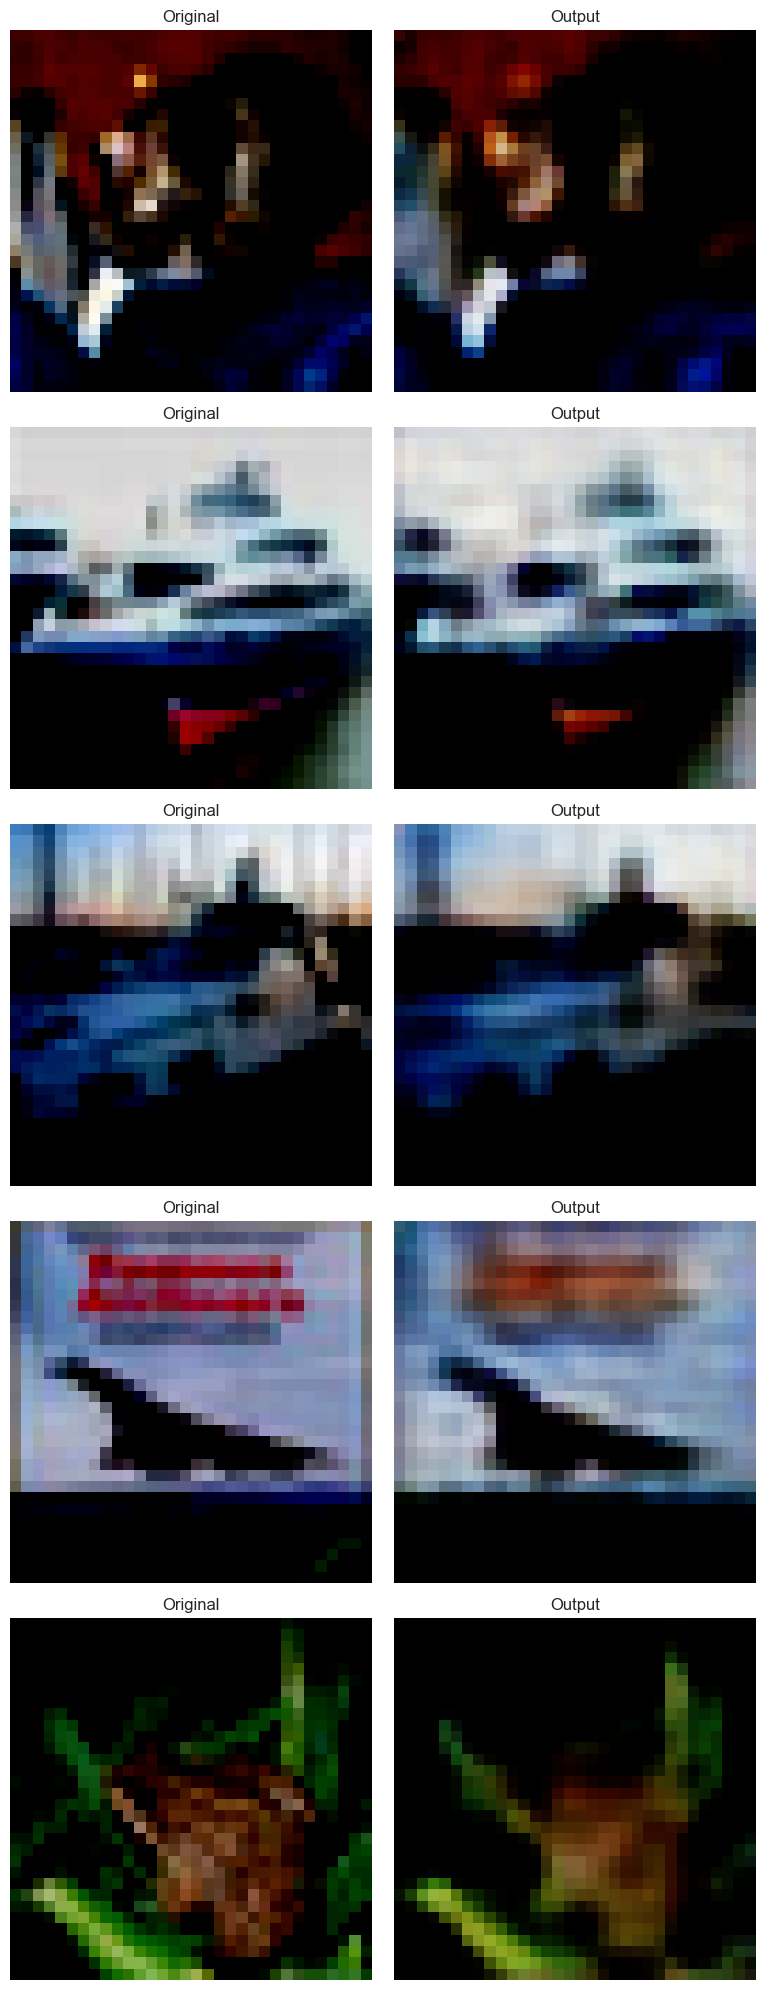

In [117]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
autoencoder.eval()
with torch.no_grad():
    outputs = autoencoder(images)

images_cpu = images.cpu()
outputs_cpu = outputs.cpu()
plot_side_by_side(images_cpu, outputs_cpu)


### Attaching classification head
Now let's attach classification head to encoder part of autoencoder

In [118]:
class SelfSupervised(nn.Module):
    def __init__(self, encoder):
        super(SelfSupervised, self).__init__()
        # Fix the encoder's weights
        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Classification head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(48 * 4 * 4, 512),  # Increase the number of hidden units
            nn.ReLU(),
            nn.Dropout(0.2),  # Adding dropout for regularization
            nn.Linear(512, 256),  # Further increasing the number of hidden units
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 10) 
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)


# Create the classifier using the encoder part of the autoencoder
self_supervised_model = SelfSupervised(autoencoder.encoder)
self_supervised_model.to(device)
print(self_supervised_model)

SelfSupervised(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=768, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)


### Define train and test functions

In [119]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    iteration = 0
    length = 0

    bar = tqdm(train_loader)
    for data, _, labels in bar:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()

        output = model(data)
        # Get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        length += len(data)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        iteration += 1
        bar.set_postfix({"Loss": format(epoch_loss / iteration, '.6f')})

    acc = 100. * correct / length
    print(f'\rTrain Epoch: {epoch}, elapsed time:{time() - start_time:.2f}s')
    return epoch_loss, acc


def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(test_loader.dataset)
    return test_loss, acc

### Define hyperparameters for sel-supervised model

In [120]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(self_supervised_model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3,
                                           patience=3, min_lr=0.0000001)
early_stopping = EarlyStopping(tolerance=7, mode='min')

best_model_wts = deepcopy(self_supervised_model.state_dict())

### Training self-supervised model

100%|██████████| 20/20 [00:01<00:00, 11.51it/s, Loss=2.309203]


Train Epoch: 1, elapsed time:1.74s
Training accuracy 12.7, test accuracy 19.64
Training loss 46.18406653404236, test loss 88.67664766311646


100%|██████████| 20/20 [00:01<00:00, 11.59it/s, Loss=2.204035]


Train Epoch: 2, elapsed time:1.73s
Training accuracy 18.34, test accuracy 25.81
Training loss 44.08069562911987, test loss 85.15761113166809


100%|██████████| 20/20 [00:01<00:00, 11.33it/s, Loss=2.141756]


Train Epoch: 3, elapsed time:1.77s
Training accuracy 22.08, test accuracy 27.75
Training loss 42.835113525390625, test loss 82.73033809661865


100%|██████████| 20/20 [00:01<00:00, 11.43it/s, Loss=2.078855]


Train Epoch: 4, elapsed time:1.75s
Training accuracy 24.4, test accuracy 26.7
Training loss 41.57709515094757, test loss 81.23436212539673


100%|██████████| 20/20 [00:01<00:00, 11.43it/s, Loss=2.042742]


Train Epoch: 5, elapsed time:1.75s
Training accuracy 26.12, test accuracy 29.99
Training loss 40.85483181476593, test loss 79.46584725379944


100%|██████████| 20/20 [00:01<00:00, 11.27it/s, Loss=2.009052]


Train Epoch: 6, elapsed time:1.78s
Training accuracy 27.46, test accuracy 29.61
Training loss 40.181031227111816, test loss 78.43273055553436


100%|██████████| 20/20 [00:01<00:00, 11.30it/s, Loss=1.986754]


Train Epoch: 7, elapsed time:1.77s
Training accuracy 29.04, test accuracy 31.65
Training loss 39.73507463932037, test loss 77.38985812664032


100%|██████████| 20/20 [00:01<00:00, 11.38it/s, Loss=1.955981]


Train Epoch: 8, elapsed time:1.76s
Training accuracy 29.9, test accuracy 31.96
Training loss 39.11961877346039, test loss 76.78818464279175


100%|██████████| 20/20 [00:01<00:00, 11.47it/s, Loss=1.925290]


Train Epoch: 9, elapsed time:1.75s
Training accuracy 31.68, test accuracy 32.7
Training loss 38.505799531936646, test loss 75.87380278110504


100%|██████████| 20/20 [00:01<00:00, 11.19it/s, Loss=1.912899]


Train Epoch: 10, elapsed time:1.79s
Training accuracy 31.02, test accuracy 33.42
Training loss 38.25798285007477, test loss 75.3844610452652


100%|██████████| 20/20 [00:01<00:00, 11.49it/s, Loss=1.897755]


Train Epoch: 11, elapsed time:1.74s
Training accuracy 32.24, test accuracy 33.51
Training loss 37.95509922504425, test loss 74.79346656799316


100%|██████████| 20/20 [00:01<00:00, 11.58it/s, Loss=1.877600]


Train Epoch: 12, elapsed time:1.73s
Training accuracy 33.06, test accuracy 33.79
Training loss 37.55200958251953, test loss 74.37304198741913


100%|██████████| 20/20 [00:01<00:00, 11.32it/s, Loss=1.869578]


Train Epoch: 13, elapsed time:1.77s
Training accuracy 32.78, test accuracy 34.41
Training loss 37.39156711101532, test loss 73.80841553211212


100%|██████████| 20/20 [00:01<00:00, 11.33it/s, Loss=1.845797]


Train Epoch: 14, elapsed time:1.77s
Training accuracy 34.08, test accuracy 34.76
Training loss 36.91594457626343, test loss 73.19194865226746


100%|██████████| 20/20 [00:01<00:00, 11.45it/s, Loss=1.841206]


Train Epoch: 15, elapsed time:1.75s
Training accuracy 34.76, test accuracy 33.62
Training loss 36.82412612438202, test loss 74.44881403446198


100%|██████████| 20/20 [00:01<00:00, 11.09it/s, Loss=1.832322]


Train Epoch: 16, elapsed time:1.81s
Training accuracy 35.14, test accuracy 35.27
Training loss 36.646438002586365, test loss 72.62740850448608


100%|██████████| 20/20 [00:01<00:00, 10.59it/s, Loss=1.808429]


Train Epoch: 17, elapsed time:1.89s
Training accuracy 36.22, test accuracy 35.54
Training loss 36.168580055236816, test loss 72.35191941261292


100%|██████████| 20/20 [00:01<00:00, 11.26it/s, Loss=1.794583]


Train Epoch: 18, elapsed time:1.78s
Training accuracy 36.7, test accuracy 35.45
Training loss 35.891669392585754, test loss 72.2925398349762


100%|██████████| 20/20 [00:01<00:00, 10.16it/s, Loss=1.792001]


Train Epoch: 19, elapsed time:1.97s
Training accuracy 35.3, test accuracy 35.89
Training loss 35.840017199516296, test loss 72.28819215297699


100%|██████████| 20/20 [00:01<00:00, 11.21it/s, Loss=1.782902]


Train Epoch: 20, elapsed time:1.79s
Training accuracy 36.72, test accuracy 36.73
Training loss 35.65803921222687, test loss 71.3143697977066


100%|██████████| 20/20 [00:01<00:00, 11.21it/s, Loss=1.763377]


Train Epoch: 21, elapsed time:1.79s
Training accuracy 37.38, test accuracy 37.35
Training loss 35.2675461769104, test loss 71.26191306114197


100%|██████████| 20/20 [00:01<00:00, 11.13it/s, Loss=1.755886]


Train Epoch: 22, elapsed time:1.80s
Training accuracy 37.8, test accuracy 37.18
Training loss 35.11772382259369, test loss 70.85332262516022


100%|██████████| 20/20 [00:01<00:00, 11.38it/s, Loss=1.745280]


Train Epoch: 23, elapsed time:1.76s
Training accuracy 37.92, test accuracy 37.84
Training loss 34.905590891838074, test loss 70.43753910064697


100%|██████████| 20/20 [00:01<00:00, 11.55it/s, Loss=1.739677]


Train Epoch: 24, elapsed time:1.73s
Training accuracy 37.74, test accuracy 37.65
Training loss 34.79353141784668, test loss 70.6268321275711


100%|██████████| 20/20 [00:01<00:00, 11.36it/s, Loss=1.739554]


Train Epoch: 25, elapsed time:1.76s
Training accuracy 37.88, test accuracy 37.17
Training loss 34.791083455085754, test loss 70.29958260059357


100%|██████████| 20/20 [00:01<00:00, 11.20it/s, Loss=1.717932]


Train Epoch: 26, elapsed time:1.79s
Training accuracy 39.12, test accuracy 38.23
Training loss 34.358636140823364, test loss 69.69612443447113


100%|██████████| 20/20 [00:01<00:00, 11.28it/s, Loss=1.714098]


Train Epoch: 27, elapsed time:1.77s
Training accuracy 39.08, test accuracy 37.64
Training loss 34.28195023536682, test loss 70.60125184059143


100%|██████████| 20/20 [00:01<00:00, 11.43it/s, Loss=1.708175]


Train Epoch: 28, elapsed time:1.75s
Training accuracy 39.36, test accuracy 38.05
Training loss 34.16349911689758, test loss 69.42015254497528


100%|██████████| 20/20 [00:01<00:00, 11.14it/s, Loss=1.697979]


Train Epoch: 29, elapsed time:1.80s
Training accuracy 40.18, test accuracy 38.3
Training loss 33.95958459377289, test loss 69.33202087879181


100%|██████████| 20/20 [00:01<00:00, 11.34it/s, Loss=1.697029]


Train Epoch: 30, elapsed time:1.77s
Training accuracy 39.76, test accuracy 38.87
Training loss 33.940589904785156, test loss 69.16163241863251


100%|██████████| 20/20 [00:01<00:00, 11.14it/s, Loss=1.695428]


Train Epoch: 31, elapsed time:1.80s
Training accuracy 40.26, test accuracy 37.16
Training loss 33.90855896472931, test loss 70.38209772109985


100%|██████████| 20/20 [00:01<00:00, 11.05it/s, Loss=1.669073]


Train Epoch: 32, elapsed time:1.81s
Training accuracy 40.98, test accuracy 38.73
Training loss 33.38146221637726, test loss 68.86424481868744


100%|██████████| 20/20 [00:01<00:00, 10.90it/s, Loss=1.666421]


Train Epoch: 33, elapsed time:1.84s
Training accuracy 41.28, test accuracy 39.36
Training loss 33.32842814922333, test loss 68.85193490982056


100%|██████████| 20/20 [00:01<00:00, 10.80it/s, Loss=1.665331]


Train Epoch: 34, elapsed time:1.85s
Training accuracy 41.9, test accuracy 38.95
Training loss 33.30662024021149, test loss 68.73263537883759


100%|██████████| 20/20 [00:01<00:00, 11.28it/s, Loss=1.643068]


Train Epoch: 35, elapsed time:1.77s
Training accuracy 42.42, test accuracy 39.56
Training loss 32.86135673522949, test loss 68.81889116764069


100%|██████████| 20/20 [00:01<00:00, 11.05it/s, Loss=1.645129]


Train Epoch: 36, elapsed time:1.81s
Training accuracy 42.26, test accuracy 39.86
Training loss 32.902573227882385, test loss 67.9585884809494


100%|██████████| 20/20 [00:01<00:00, 11.13it/s, Loss=1.635589]


Train Epoch: 37, elapsed time:1.80s
Training accuracy 41.78, test accuracy 39.48
Training loss 32.71178889274597, test loss 68.34028995037079


100%|██████████| 20/20 [00:01<00:00, 10.65it/s, Loss=1.638720]


Train Epoch: 38, elapsed time:1.88s
Training accuracy 41.22, test accuracy 40.46
Training loss 32.774409532547, test loss 67.52835893630981


100%|██████████| 20/20 [00:01<00:00, 11.13it/s, Loss=1.621646]


Train Epoch: 39, elapsed time:1.80s
Training accuracy 43.26, test accuracy 39.82
Training loss 32.43291258811951, test loss 67.7906424999237


100%|██████████| 20/20 [00:01<00:00, 11.33it/s, Loss=1.617127]


Train Epoch: 40, elapsed time:1.77s
Training accuracy 43.12, test accuracy 39.6
Training loss 32.34254765510559, test loss 67.46511363983154


100%|██████████| 20/20 [00:01<00:00, 11.30it/s, Loss=1.599540]


Train Epoch: 41, elapsed time:1.77s
Training accuracy 43.66, test accuracy 39.96
Training loss 31.990803122520447, test loss 67.7593367099762


100%|██████████| 20/20 [00:01<00:00, 11.24it/s, Loss=1.604022]


Train Epoch: 42, elapsed time:1.78s
Training accuracy 44.28, test accuracy 40.07
Training loss 32.08043956756592, test loss 67.53607261180878


100%|██████████| 20/20 [00:01<00:00, 11.26it/s, Loss=1.589308]


Train Epoch: 43, elapsed time:1.78s
Training accuracy 43.88, test accuracy 40.68
Training loss 31.786166191101074, test loss 66.78345191478729


100%|██████████| 20/20 [00:01<00:00, 11.33it/s, Loss=1.579946]


Train Epoch: 44, elapsed time:1.77s
Training accuracy 44.64, test accuracy 41.32
Training loss 31.5989248752594, test loss 66.80532360076904


100%|██████████| 20/20 [00:01<00:00, 11.31it/s, Loss=1.567870]


Train Epoch: 45, elapsed time:1.77s
Training accuracy 45.48, test accuracy 39.96
Training loss 31.357399940490723, test loss 67.0595338344574


100%|██████████| 20/20 [00:01<00:00, 11.29it/s, Loss=1.577451]


Train Epoch: 46, elapsed time:1.77s
Training accuracy 44.6, test accuracy 40.52
Training loss 31.549026012420654, test loss 67.02621614933014


100%|██████████| 20/20 [00:01<00:00, 11.08it/s, Loss=1.557339]


Train Epoch: 47, elapsed time:1.81s
Training accuracy 45.14, test accuracy 40.68
Training loss 31.14677369594574, test loss 66.47104465961456


100%|██████████| 20/20 [00:01<00:00, 11.49it/s, Loss=1.547375]


Train Epoch: 48, elapsed time:1.74s
Training accuracy 45.7, test accuracy 41.36
Training loss 30.947508811950684, test loss 66.361896276474


100%|██████████| 20/20 [00:01<00:00, 11.40it/s, Loss=1.543784]


Train Epoch: 49, elapsed time:1.76s
Training accuracy 45.68, test accuracy 40.89
Training loss 30.875672221183777, test loss 66.69114100933075


100%|██████████| 20/20 [00:01<00:00, 11.27it/s, Loss=1.545755]


Train Epoch: 50, elapsed time:1.78s
Training accuracy 45.58, test accuracy 41.43
Training loss 30.915104627609253, test loss 66.28528380393982


100%|██████████| 20/20 [00:01<00:00, 11.52it/s, Loss=1.535289]


Train Epoch: 51, elapsed time:1.74s
Training accuracy 46.46, test accuracy 40.95
Training loss 30.70578896999359, test loss 66.32423400878906


100%|██████████| 20/20 [00:01<00:00, 11.45it/s, Loss=1.540687]


Train Epoch: 52, elapsed time:1.75s
Training accuracy 46.3, test accuracy 41.5
Training loss 30.813746571540833, test loss 65.75224983692169


100%|██████████| 20/20 [00:01<00:00, 11.07it/s, Loss=1.527449]


Train Epoch: 53, elapsed time:1.81s
Training accuracy 46.6, test accuracy 41.15
Training loss 30.5489844083786, test loss 66.26313626766205


100%|██████████| 20/20 [00:01<00:00, 11.06it/s, Loss=1.519855]


Train Epoch: 54, elapsed time:1.81s
Training accuracy 46.8, test accuracy 41.82
Training loss 30.397098302841187, test loss 65.59455120563507


100%|██████████| 20/20 [00:01<00:00, 11.06it/s, Loss=1.523006]


Train Epoch: 55, elapsed time:1.81s
Training accuracy 46.46, test accuracy 41.49
Training loss 30.460124850273132, test loss 65.82125329971313


100%|██████████| 20/20 [00:01<00:00, 11.04it/s, Loss=1.502909]


Train Epoch: 56, elapsed time:1.81s
Training accuracy 46.1, test accuracy 41.11
Training loss 30.058178782463074, test loss 66.17143130302429


100%|██████████| 20/20 [00:01<00:00, 11.16it/s, Loss=1.504056]


Train Epoch: 57, elapsed time:1.79s
Training accuracy 48.08, test accuracy 42.01
Training loss 30.08112061023712, test loss 65.25216162204742


100%|██████████| 20/20 [00:01<00:00, 10.31it/s, Loss=1.500725]


Train Epoch: 58, elapsed time:1.94s
Training accuracy 46.96, test accuracy 41.81
Training loss 30.014503002166748, test loss 65.58556711673737


100%|██████████| 20/20 [00:01<00:00, 11.02it/s, Loss=1.486311]


Train Epoch: 59, elapsed time:1.82s
Training accuracy 47.42, test accuracy 41.51
Training loss 29.726210236549377, test loss 66.19914376735687


100%|██████████| 20/20 [00:01<00:00, 11.03it/s, Loss=1.487168]


Train Epoch: 60, elapsed time:1.82s
Training accuracy 47.22, test accuracy 42.14
Training loss 29.74335014820099, test loss 65.49232864379883


100%|██████████| 20/20 [00:01<00:00, 11.25it/s, Loss=1.478783]


Train Epoch: 61, elapsed time:1.78s
Training accuracy 48.1, test accuracy 42.02
Training loss 29.575664401054382, test loss 65.3884506225586


100%|██████████| 20/20 [00:01<00:00, 10.91it/s, Loss=1.457308]


Train Epoch: 62, elapsed time:1.84s
Training accuracy 47.64, test accuracy 41.92
Training loss 29.14615511894226, test loss 65.20533430576324


100%|██████████| 20/20 [00:01<00:00, 10.96it/s, Loss=1.460484]


Train Epoch: 63, elapsed time:1.83s
Training accuracy 48.8, test accuracy 42.3
Training loss 29.20968759059906, test loss 65.41587901115417


100%|██████████| 20/20 [00:01<00:00, 10.94it/s, Loss=1.465027]


Train Epoch: 64, elapsed time:1.83s
Training accuracy 48.36, test accuracy 42.08
Training loss 29.300532937049866, test loss 65.25103735923767


100%|██████████| 20/20 [00:01<00:00, 10.89it/s, Loss=1.444539]


Train Epoch: 65, elapsed time:1.84s
Training accuracy 48.92, test accuracy 42.32
Training loss 28.8907870054245, test loss 64.91517281532288


100%|██████████| 20/20 [00:01<00:00, 11.02it/s, Loss=1.448488]


Train Epoch: 66, elapsed time:1.82s
Training accuracy 48.74, test accuracy 41.76
Training loss 28.96975612640381, test loss 65.58154034614563


100%|██████████| 20/20 [00:01<00:00, 10.93it/s, Loss=1.456670]


Train Epoch: 67, elapsed time:1.83s
Training accuracy 48.38, test accuracy 42.59
Training loss 29.133403301239014, test loss 64.93577206134796


100%|██████████| 20/20 [00:01<00:00, 10.93it/s, Loss=1.427261]


Train Epoch: 68, elapsed time:1.83s
Training accuracy 49.9, test accuracy 42.2
Training loss 28.545228600502014, test loss 65.11608791351318


100%|██████████| 20/20 [00:01<00:00, 10.99it/s, Loss=1.429935]


Train Epoch: 69, elapsed time:1.82s
Training accuracy 49.7, test accuracy 42.02
Training loss 28.59869122505188, test loss 64.78770339488983


100%|██████████| 20/20 [00:01<00:00, 11.18it/s, Loss=1.412677]


Train Epoch: 70, elapsed time:1.79s
Training accuracy 50.02, test accuracy 43.1
Training loss 28.25353467464447, test loss 64.80965197086334


100%|██████████| 20/20 [00:01<00:00, 11.26it/s, Loss=1.409656]


Train Epoch: 71, elapsed time:1.78s
Training accuracy 50.74, test accuracy 42.86
Training loss 28.193117022514343, test loss 64.68308281898499


100%|██████████| 20/20 [00:01<00:00, 11.17it/s, Loss=1.398560]


Train Epoch: 72, elapsed time:1.79s
Training accuracy 51.18, test accuracy 42.4
Training loss 27.971195340156555, test loss 64.47918629646301


100%|██████████| 20/20 [00:01<00:00, 10.97it/s, Loss=1.413399]


Train Epoch: 73, elapsed time:1.82s
Training accuracy 50.54, test accuracy 42.69
Training loss 28.267974734306335, test loss 64.28967499732971


100%|██████████| 20/20 [00:01<00:00, 11.05it/s, Loss=1.407014]


Train Epoch: 74, elapsed time:1.81s
Training accuracy 50.28, test accuracy 43.63
Training loss 28.14027714729309, test loss 64.18680083751678


100%|██████████| 20/20 [00:01<00:00, 10.93it/s, Loss=1.389226]


Train Epoch: 75, elapsed time:1.83s
Training accuracy 51.68, test accuracy 43.02
Training loss 27.7845139503479, test loss 64.77402782440186


100%|██████████| 20/20 [00:01<00:00, 11.12it/s, Loss=1.397760]


Train Epoch: 76, elapsed time:1.80s
Training accuracy 50.92, test accuracy 43.55
Training loss 27.955204963684082, test loss 64.13089764118195


100%|██████████| 20/20 [00:01<00:00, 10.10it/s, Loss=1.377304]


Train Epoch: 77, elapsed time:1.98s
Training accuracy 51.34, test accuracy 41.68
Training loss 27.546070098876953, test loss 65.37382054328918


100%|██████████| 20/20 [00:01<00:00, 11.20it/s, Loss=1.374189]


Train Epoch: 78, elapsed time:1.79s
Training accuracy 52.22, test accuracy 42.2
Training loss 27.483785033226013, test loss 65.10072827339172


100%|██████████| 20/20 [00:01<00:00, 10.92it/s, Loss=1.371054]


Train Epoch: 79, elapsed time:1.83s
Training accuracy 51.8, test accuracy 42.95
Training loss 27.421082258224487, test loss 64.3728996515274


100%|██████████| 20/20 [00:01<00:00, 11.21it/s, Loss=1.366271]


Train Epoch: 80, elapsed time:1.79s
Training accuracy 52.08, test accuracy 42.12
Training loss 27.325424194335938, test loss 65.3773045539856


100%|██████████| 20/20 [00:01<00:00, 11.39it/s, Loss=1.378417]


Train Epoch: 81, elapsed time:1.76s
Training accuracy 51.42, test accuracy 42.78
Training loss 27.56834626197815, test loss 64.08188390731812


100%|██████████| 20/20 [00:01<00:00, 11.14it/s, Loss=1.362640]


Train Epoch: 82, elapsed time:1.80s
Training accuracy 52.14, test accuracy 43.23
Training loss 27.252792239189148, test loss 64.22805905342102


100%|██████████| 20/20 [00:01<00:00, 11.04it/s, Loss=1.351460]


Train Epoch: 83, elapsed time:1.81s
Training accuracy 53.04, test accuracy 43.56
Training loss 27.02920913696289, test loss 63.83122634887695


100%|██████████| 20/20 [00:01<00:00, 11.14it/s, Loss=1.346880]


Train Epoch: 84, elapsed time:1.80s
Training accuracy 53.52, test accuracy 43.05
Training loss 26.937601804733276, test loss 63.92365372180939


100%|██████████| 20/20 [00:01<00:00, 11.34it/s, Loss=1.348262]


Train Epoch: 85, elapsed time:1.77s
Training accuracy 53.52, test accuracy 43.09
Training loss 26.965232729911804, test loss 64.42648673057556


100%|██████████| 20/20 [00:01<00:00, 11.09it/s, Loss=1.351092]


Train Epoch: 86, elapsed time:1.81s
Training accuracy 52.62, test accuracy 42.2
Training loss 27.021849989891052, test loss 66.23801267147064


100%|██████████| 20/20 [00:01<00:00, 11.15it/s, Loss=1.342542]


Train Epoch: 87, elapsed time:1.80s
Training accuracy 52.64, test accuracy 42.76
Training loss 26.850834131240845, test loss 64.58750581741333


100%|██████████| 20/20 [00:01<00:00, 10.98it/s, Loss=1.339875]


Train Epoch: 88, elapsed time:1.82s
Training accuracy 53.12, test accuracy 43.44
Training loss 26.79749608039856, test loss 63.89844369888306


100%|██████████| 20/20 [00:01<00:00, 11.20it/s, Loss=1.334365]


Train Epoch: 89, elapsed time:1.79s
Training accuracy 52.64, test accuracy 43.67
Training loss 26.687295794487, test loss 63.83909368515015


100%|██████████| 20/20 [00:01<00:00, 10.97it/s, Loss=1.326146]


Train Epoch: 90, elapsed time:1.83s

Early stopping


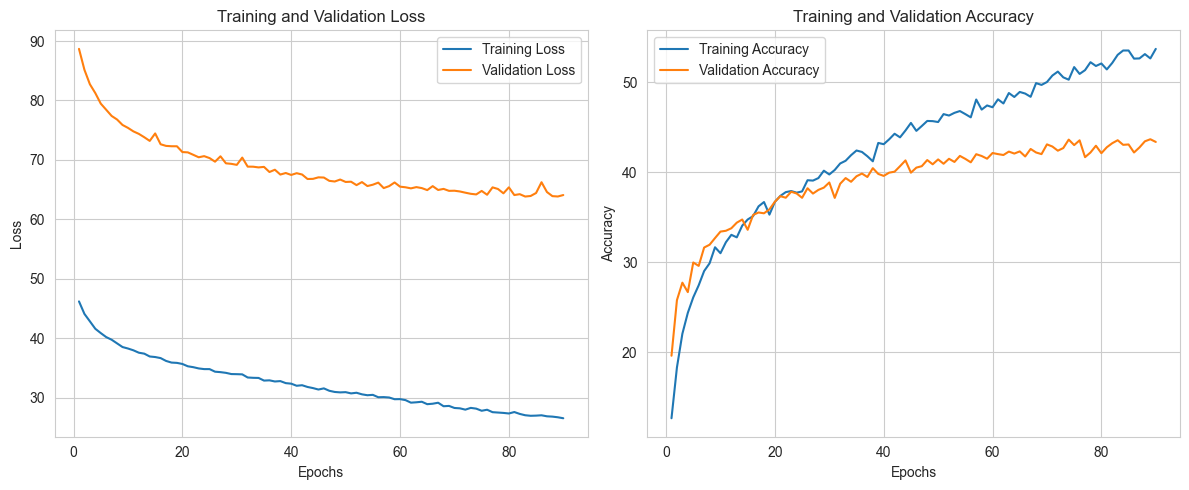

In [121]:
epochs = 100

def training():
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_acc = 0.0
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(self_supervised_model, device, train_loader_noisy_10, criterion, optimizer, epoch)
        scheduler.step(train_loss)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        test_loss, test_acc = test(self_supervised_model, device, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Terminate training if loss stopped to decrease
        if early_stopping(test_loss):
            print('\nEarly stopping\n')
            break
        # Deep copy the weight of model if its accuracy is the best for now
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(self_supervised_model.state_dict())
            
        print(f"Training accuracy {train_acc}, test accuracy {test_acc}")
        print(f"Training loss {train_loss}, test loss {test_loss}")

    self_supervised_model.load_state_dict(best_model_wts)
    torch.save(self_supervised_model.state_dict(), "best_self_supervised_model.pt")

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epoch + 1), test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epoch + 1), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


training()

## Task 3. Auxiliary learning [12 pts]
For this task I used [Deep Reconstruction-Classification Network for Unsupervised Domain Adaptation](https://link.springer.com/chapter/10.1007/978-3-319-46493-0_36) article

### Define test and training function for DRCN model

In [122]:

def train_drcn(model, device, train_loader, classifier_criterion, decoder_criterion, optimizer, epoch, lamda=0.1):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    iteration = 0
    length = 0

    bar = tqdm(train_loader)
    # learning classifier
    for data, _, lebel in bar:
        data, lebel = data.to(device), lebel.to(device)
        optimizer.zero_grad()
        _, outputs = model(data)

        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(lebel.view_as(pred)).sum().item()
        length += len(data)

        loss = lamda * classifier_criterion(outputs, lebel)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        iteration += 1
        bar.set_postfix({"Loss": format(epoch_loss / iteration, '.6f')})
        
    bar = tqdm(train_loader)
    # learning decoder
    for data, target, _ in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        decoded, _ = model(data)

        loss = (1 - lamda) * decoder_criterion(decoded, target)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        iteration += 1
        bar.set_postfix({"Loss": format(epoch_loss / iteration, '.6f')})

    acc = 100. * correct / length
    print(f'\rTrain Epoch: {epoch}, elapsed time:{time() - start_time:.2f}s')
    return epoch_loss, acc


def test_drcn(model, device, test_loader, classifier_criterion, decoder_criterion, lamda=0.1):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            decoded, output = model(data)
            classific_loss = classifier_criterion(output, target)
            decoder_loss = decoder_criterion(decoded, data)
            loss = lamda * classific_loss + (1 - lamda) * decoder_loss
            test_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(test_loader.dataset)
    return test_loss, acc

## DRCN model

### Encoder
- **Convolutional Layers**: 
  - Input Channels: 3 (RGB images)
  - Output Channels: 64, 128, 256
  - Kernel Size: 3x3
  - Padding: 1
- **Activation Function**: ReLU
- **Pooling**: Max pooling with kernel size 2x2 and stride 2

The encoder extracts hierarchical features from the input image, gradually reducing its spatial dimensions while increasing the number of channels.

### Decoder
- **Transposed Convolutional Layers**:
  - Input Channels: 256
  - Output Channels: 128, 64, 3 (RGB channels)
  - Kernel Size: 2x2
  - Stride: 2
- **Activation Function**: ReLU (except for the last layer, which uses Sigmoid)

The decoder reconstructs the original input image from the encoded representation obtained by the encoder.

### Classification Layer
- **Fully Connected Layers**:
  - Input Size: 256 * 4 * 4 (Flattened output of the encoder)
  - Output Size: 10 (Number of classes)
- **Batch Normalization**: Applied to the output of the first fully connected layer
- **Activation Function**: ReLU
- **Dropout**: Regularization with a dropout rate of 0.5
- **Output Activation**: Log softmax

The classification layer takes the encoded representation as input and predicts the class labels for the input images.


In [123]:
# Define the DRCN model
class DRCN(nn.Module):
    def __init__(self):
        super(DRCN, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Dimension: (batch_size, 256, 4, 4)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Sigmoid()  # Output: (batch_size, 3, 32, 32)
        )
        # Classification layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        output = self.classifier(encoded)
        output = F.log_softmax(output, dim=1)
        return decoded, output


drcn_model = DRCN().to(device)

### Define hyperparameters

In [124]:
classifier_criterion = nn.CrossEntropyLoss()
decoder_criterion = nn.MSELoss()
optimizer = Adam(drcn_model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3,
                                           patience=3, min_lr=0.0000001)
early_stopping = EarlyStopping(tolerance=7, mode='min')

### Training DRCN model

100%|██████████| 20/20 [00:02<00:00,  9.57it/s, Loss=0.346751]


Train Epoch: 1, elapsed time:4.22s
Training accuracy 29.44, test accuracy 39.21
Training loss 13.870047196745872, test loss 27.92584979534149


100%|██████████| 20/20 [00:02<00:00,  9.27it/s, Loss=0.327556]


Train Epoch: 2, elapsed time:4.19s
Training accuracy 42.88, test accuracy 44.94
Training loss 13.102222934365273, test loss 25.588701903820038


100%|██████████| 20/20 [00:02<00:00,  9.28it/s, Loss=0.310890]


Train Epoch: 3, elapsed time:4.35s
Training accuracy 47.76, test accuracy 37.84
Training loss 12.435588255524635, test loss 25.216636896133423


100%|██████████| 20/20 [00:02<00:00,  9.56it/s, Loss=0.261697]


Train Epoch: 4, elapsed time:4.15s
Training accuracy 48.72, test accuracy 24.68
Training loss 10.467864885926247, test loss 22.247262060642242


100%|██████████| 20/20 [00:02<00:00,  9.53it/s, Loss=0.206248]


Train Epoch: 5, elapsed time:4.09s
Training accuracy 40.26, test accuracy 41.87
Training loss 8.249916017055511, test loss 15.414881408214569


100%|██████████| 20/20 [00:02<00:00,  9.34it/s, Loss=0.192427]


Train Epoch: 6, elapsed time:4.16s
Training accuracy 43.16, test accuracy 43.56
Training loss 7.697073340415955, test loss 15.034983068704605


100%|██████████| 20/20 [00:02<00:00,  9.71it/s, Loss=0.184661]


Train Epoch: 7, elapsed time:4.01s
Training accuracy 47.24, test accuracy 44.77
Training loss 7.3864553570747375, test loss 14.549857884645462


100%|██████████| 20/20 [00:02<00:00,  9.58it/s, Loss=0.177844]


Train Epoch: 8, elapsed time:4.04s
Training accuracy 48.86, test accuracy 45.74
Training loss 7.113744452595711, test loss 14.084270864725113


100%|██████████| 20/20 [00:02<00:00,  9.43it/s, Loss=0.170779]


Train Epoch: 9, elapsed time:4.12s
Training accuracy 49.94, test accuracy 46.95
Training loss 6.831168860197067, test loss 13.634903997182846


100%|██████████| 20/20 [00:02<00:00,  9.39it/s, Loss=0.165996]


Train Epoch: 10, elapsed time:4.14s
Training accuracy 51.36, test accuracy 47.91
Training loss 6.639852732419968, test loss 13.236294090747833


100%|██████████| 20/20 [00:02<00:00,  9.44it/s, Loss=0.161781]


Train Epoch: 11, elapsed time:4.05s
Training accuracy 51.44, test accuracy 49.0
Training loss 6.471225216984749, test loss 12.992288380861282


100%|██████████| 20/20 [00:02<00:00,  9.38it/s, Loss=0.157175]


Train Epoch: 12, elapsed time:4.10s
Training accuracy 53.76, test accuracy 49.91
Training loss 6.287014804780483, test loss 12.778292566537857


100%|██████████| 20/20 [00:02<00:00,  9.17it/s, Loss=0.153810]


Train Epoch: 13, elapsed time:4.36s
Training accuracy 55.06, test accuracy 50.52
Training loss 6.152391843497753, test loss 12.612380892038345


100%|██████████| 20/20 [00:02<00:00,  9.47it/s, Loss=0.151009]


Train Epoch: 14, elapsed time:4.12s
Training accuracy 56.22, test accuracy 51.54
Training loss 6.040366567671299, test loss 12.442392528057098


100%|██████████| 20/20 [00:02<00:00,  9.39it/s, Loss=0.147942]


Train Epoch: 15, elapsed time:4.14s
Training accuracy 58.78, test accuracy 51.42
Training loss 5.917667433619499, test loss 12.369243115186691


100%|██████████| 20/20 [00:02<00:00,  9.05it/s, Loss=0.144408]


Train Epoch: 16, elapsed time:4.25s
Training accuracy 59.82, test accuracy 51.61
Training loss 5.776315942406654, test loss 12.21867322921753


100%|██████████| 20/20 [00:02<00:00,  8.98it/s, Loss=0.141388]


Train Epoch: 17, elapsed time:4.26s
Training accuracy 62.1, test accuracy 53.36
Training loss 5.655527517199516, test loss 11.990787029266357


100%|██████████| 20/20 [00:02<00:00,  8.87it/s, Loss=0.137690]


Train Epoch: 18, elapsed time:4.31s
Training accuracy 63.88, test accuracy 52.99
Training loss 5.507586531341076, test loss 11.874202370643616


100%|██████████| 20/20 [00:02<00:00,  9.08it/s, Loss=0.134982]


Train Epoch: 19, elapsed time:4.17s
Training accuracy 65.18, test accuracy 53.37
Training loss 5.399287976324558, test loss 11.801004350185394


100%|██████████| 20/20 [00:02<00:00,  9.30it/s, Loss=0.132801]


Train Epoch: 20, elapsed time:4.21s
Training accuracy 66.18, test accuracy 53.19
Training loss 5.312056809663773, test loss 11.739780396223068


100%|██████████| 20/20 [00:02<00:00,  9.41it/s, Loss=0.130514]


Train Epoch: 21, elapsed time:4.10s
Training accuracy 68.32, test accuracy 54.62
Training loss 5.220542937517166, test loss 11.570522159337997


100%|██████████| 20/20 [00:02<00:00,  8.85it/s, Loss=0.128122]


Train Epoch: 22, elapsed time:4.19s
Training accuracy 69.36, test accuracy 54.38
Training loss 5.124892108142376, test loss 11.514256805181503


100%|██████████| 20/20 [00:02<00:00,  9.72it/s, Loss=0.125985]


Train Epoch: 23, elapsed time:4.05s
Training accuracy 70.16, test accuracy 50.95
Training loss 5.039390608668327, test loss 12.042419761419296


100%|██████████| 20/20 [00:02<00:00,  9.26it/s, Loss=0.125460]


Train Epoch: 24, elapsed time:4.18s
Training accuracy 70.64, test accuracy 54.69
Training loss 5.018415093421936, test loss 11.363314926624298


100%|██████████| 20/20 [00:02<00:00,  9.63it/s, Loss=0.121847]


Train Epoch: 25, elapsed time:4.05s
Training accuracy 73.1, test accuracy 54.31
Training loss 4.873882509768009, test loss 11.467150270938873


100%|██████████| 20/20 [00:02<00:00,  9.11it/s, Loss=0.119885]


Train Epoch: 26, elapsed time:4.18s
Training accuracy 74.5, test accuracy 56.06
Training loss 4.795383051037788, test loss 11.203240543603897


100%|██████████| 20/20 [00:02<00:00,  9.57it/s, Loss=0.117242]


Train Epoch: 27, elapsed time:4.08s
Training accuracy 76.86, test accuracy 54.46
Training loss 4.689686611294746, test loss 11.37185937166214


100%|██████████| 20/20 [00:02<00:00,  9.85it/s, Loss=0.115993]


Train Epoch: 28, elapsed time:3.96s
Training accuracy 77.34, test accuracy 55.38
Training loss 4.639738813042641, test loss 11.22621437907219


100%|██████████| 20/20 [00:02<00:00,  9.69it/s, Loss=0.113745]


Train Epoch: 29, elapsed time:4.09s
Training accuracy 79.38, test accuracy 57.33
Training loss 4.549801405519247, test loss 10.999339073896408


100%|██████████| 20/20 [00:02<00:00,  9.76it/s, Loss=0.110421]


Train Epoch: 30, elapsed time:4.01s
Training accuracy 81.98, test accuracy 57.74
Training loss 4.416845843195915, test loss 10.951209783554077


100%|██████████| 20/20 [00:02<00:00,  9.68it/s, Loss=0.109463]


Train Epoch: 31, elapsed time:4.05s
Training accuracy 82.02, test accuracy 57.38
Training loss 4.3785351030528545, test loss 10.958662271499634


100%|██████████| 20/20 [00:02<00:00,  9.52it/s, Loss=0.107813]


Train Epoch: 32, elapsed time:4.31s
Training accuracy 83.16, test accuracy 57.2
Training loss 4.312517609447241, test loss 11.008700758218765


100%|██████████| 20/20 [00:02<00:00,  9.66it/s, Loss=0.105839]


Train Epoch: 33, elapsed time:4.05s
Training accuracy 85.18, test accuracy 57.77
Training loss 4.233566414564848, test loss 10.910593807697296


100%|██████████| 20/20 [00:02<00:00,  9.26it/s, Loss=0.104541]


Train Epoch: 34, elapsed time:4.18s
Training accuracy 84.96, test accuracy 57.26
Training loss 4.181636929512024, test loss 11.009712517261505


100%|██████████| 20/20 [00:02<00:00,  9.34it/s, Loss=0.103269]


Train Epoch: 35, elapsed time:4.14s
Training accuracy 86.52, test accuracy 56.1
Training loss 4.130778793245554, test loss 11.147546291351318


100%|██████████| 20/20 [00:02<00:00,  9.11it/s, Loss=0.102177]


Train Epoch: 36, elapsed time:4.20s
Training accuracy 86.54, test accuracy 56.5
Training loss 4.087085887789726, test loss 11.097326904535294


100%|██████████| 20/20 [00:02<00:00,  9.36it/s, Loss=0.100728]


Train Epoch: 37, elapsed time:4.09s
Training accuracy 87.88, test accuracy 57.78
Training loss 4.029104460030794, test loss 10.955596655607224


100%|██████████| 20/20 [00:02<00:00,  9.70it/s, Loss=0.098597]


Train Epoch: 38, elapsed time:3.99s
Training accuracy 89.82, test accuracy 58.5
Training loss 3.9438688047230244, test loss 10.792145997285843


100%|██████████| 20/20 [00:02<00:00,  9.64it/s, Loss=0.097217]


Train Epoch: 39, elapsed time:4.06s
Training accuracy 90.82, test accuracy 56.81
Training loss 3.8886764273047447, test loss 11.073960572481155


100%|██████████| 20/20 [00:02<00:00,  9.56it/s, Loss=0.096632]


Train Epoch: 40, elapsed time:4.14s
Training accuracy 90.96, test accuracy 56.81
Training loss 3.865283377468586, test loss 11.100059062242508


100%|██████████| 20/20 [00:02<00:00,  8.73it/s, Loss=0.095534]


Train Epoch: 41, elapsed time:4.26s
Training accuracy 91.68, test accuracy 58.65
Training loss 3.821360368281603, test loss 10.863327890634537


100%|██████████| 20/20 [00:02<00:00,  9.39it/s, Loss=0.093089]


Train Epoch: 42, elapsed time:4.17s
Training accuracy 93.24, test accuracy 58.0
Training loss 3.7235697489231825, test loss 10.971387296915054


100%|██████████| 20/20 [00:02<00:00,  9.41it/s, Loss=0.092292]


Train Epoch: 43, elapsed time:4.12s
Training accuracy 94.34, test accuracy 54.38
Training loss 3.691679686307907, test loss 11.418600857257843


100%|██████████| 20/20 [00:02<00:00,  9.21it/s, Loss=0.092338]


Train Epoch: 44, elapsed time:4.30s
Training accuracy 93.26, test accuracy 55.7
Training loss 3.693527454510331, test loss 11.24700927734375


100%|██████████| 20/20 [00:02<00:00,  9.30it/s, Loss=0.091837]


Train Epoch: 45, elapsed time:4.18s

Early stopping


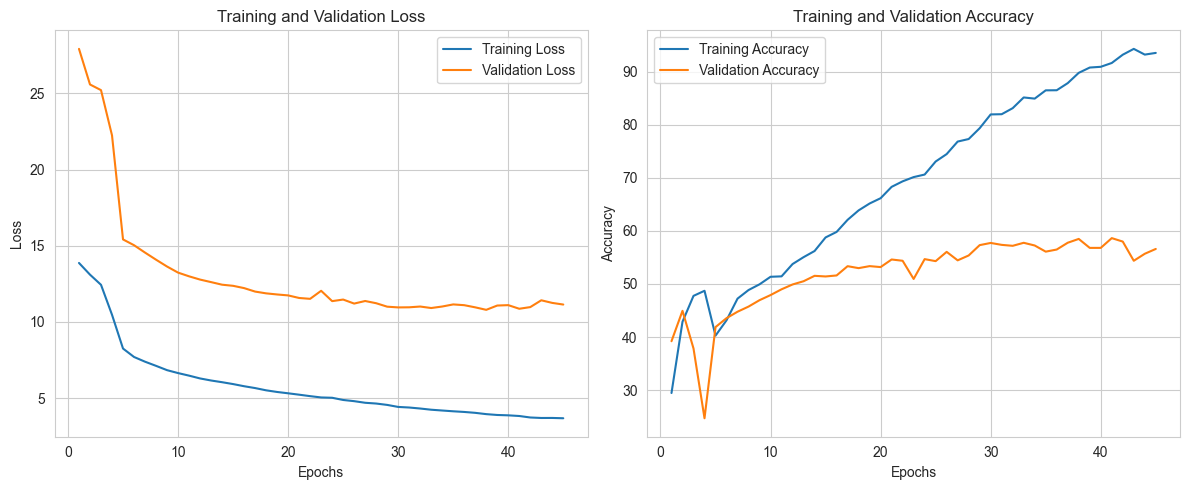

In [125]:
epochs = 100

def training_drcn():
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_acc = 0.0
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_drcn(drcn_model, device, train_loader_noisy_10, classifier_criterion,
                                               decoder_criterion, optimizer, epoch)
        scheduler.step(train_loss)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        test_loss, test_acc = test_drcn(drcn_model, device, test_loader, classifier_criterion, decoder_criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Terminate training if loss stopped to decrease
        if early_stopping(test_loss):
            print('\nEarly stopping\n')
            break
        # Deep copy the weight of model if its accuracy is the best for now
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(drcn_model.state_dict())

        print(f"Training accuracy {train_acc}, test accuracy {test_acc}")
        print(f"Training loss {train_loss}, test loss {test_loss}")

    drcn_model.load_state_dict(best_model_wts)
    torch.save(drcn_model.state_dict(), "best_drcn_model.pt")

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epoch + 1), test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epoch + 1), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


training_drcn()

## Task 4. Ensemble [6pts]
Just make stacking ensemble from three previous models

In [127]:
class Ensemble(nn.Module):
    def __init__(self, model_1, model_2, model_3):
        super(Ensemble, self).__init__()
        # freeze parameters of the models
        for param in model_1.parameters():
            param.requires_grad = False
        for param in model_2.parameters():
            param.requires_grad = False
        for param in model_3.parameters():
            param.requires_grad = False
            
        self.model_1 = model_1
        self.model_2 = model_2
        self.model_3 = model_3
            
        # Define fully connected layers for meta-model
        self.fc1 = nn.Linear(3 * 10, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        self.model_1.eval()
        self.model_2.eval()
        self.model_3.eval()
        with torch.no_grad():
            x1 = self.model_1(x)
            x2 = self.model_2(x)
            _, x3 = self.model_3(x)
            
        x = torch.cat((x1, x2, x3), dim=1)
        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
ensemble = Ensemble(baselinde_model, self_supervised_model, drcn_model)
ensemble.to(device)
print(ensemble)

Ensemble(
  (model_1): CustomModel(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv4): Sequential(
      (0): Conv2d(128, 256, k

### Define hyperparameters for Ensemble model

In [128]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(ensemble.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3,
                                           patience=3, min_lr=0.0000001)
early_stopping = EarlyStopping(tolerance=7, mode='min')

best_model_wts = deepcopy(ensemble.state_dict())

### Training ensemble

100%|██████████| 20/20 [00:02<00:00,  8.93it/s, Loss=2.775946]


Train Epoch: 1, elapsed time:2.24s
Training accuracy 10.72, test accuracy 10.13
Training loss 55.51892161369324, test loss 103.18662405014038


100%|██████████| 20/20 [00:01<00:00, 11.02it/s, Loss=2.376901]


Train Epoch: 2, elapsed time:1.82s
Training accuracy 11.72, test accuracy 10.62
Training loss 47.53801655769348, test loss 89.62492442131042


100%|██████████| 20/20 [00:01<00:00, 10.98it/s, Loss=2.127731]


Train Epoch: 3, elapsed time:1.82s
Training accuracy 15.7, test accuracy 17.79
Training loss 42.55462694168091, test loss 81.37620055675507


100%|██████████| 20/20 [00:01<00:00, 11.27it/s, Loss=1.956525]


Train Epoch: 4, elapsed time:1.78s
Training accuracy 27.98, test accuracy 30.67
Training loss 39.130499958992004, test loss 74.97563779354095


100%|██████████| 20/20 [00:01<00:00, 11.26it/s, Loss=1.807052]


Train Epoch: 5, elapsed time:1.78s
Training accuracy 41.22, test accuracy 40.88
Training loss 36.14104521274567, test loss 69.31128323078156


100%|██████████| 20/20 [00:02<00:00,  9.92it/s, Loss=1.675347]


Train Epoch: 6, elapsed time:2.02s
Training accuracy 52.06, test accuracy 49.51
Training loss 33.50693225860596, test loss 64.00977218151093


100%|██████████| 20/20 [00:01<00:00, 10.98it/s, Loss=1.555365]


Train Epoch: 7, elapsed time:1.82s
Training accuracy 59.58, test accuracy 56.94
Training loss 31.107290506362915, test loss 59.26437795162201


100%|██████████| 20/20 [00:01<00:00, 11.23it/s, Loss=1.439582]


Train Epoch: 8, elapsed time:1.78s
Training accuracy 65.84, test accuracy 61.22
Training loss 28.791648745536804, test loss 55.1679482460022


100%|██████████| 20/20 [00:01<00:00, 11.31it/s, Loss=1.340147]


Train Epoch: 9, elapsed time:1.77s
Training accuracy 71.04, test accuracy 64.15
Training loss 26.802947402000427, test loss 51.43275594711304


100%|██████████| 20/20 [00:01<00:00, 11.29it/s, Loss=1.243769]


Train Epoch: 10, elapsed time:1.77s
Training accuracy 74.84, test accuracy 66.07
Training loss 24.875385522842407, test loss 48.435614347457886


100%|██████████| 20/20 [00:01<00:00, 11.15it/s, Loss=1.160900]


Train Epoch: 11, elapsed time:1.80s
Training accuracy 76.68, test accuracy 67.78
Training loss 23.21800446510315, test loss 45.8297039270401


100%|██████████| 20/20 [00:01<00:00, 10.94it/s, Loss=1.092313]


Train Epoch: 12, elapsed time:1.83s
Training accuracy 78.72, test accuracy 68.9
Training loss 21.846259593963623, test loss 43.699100852012634


100%|██████████| 20/20 [00:01<00:00, 11.08it/s, Loss=1.029216]


Train Epoch: 13, elapsed time:1.81s
Training accuracy 79.98, test accuracy 69.71
Training loss 20.584327161312103, test loss 41.89386981725693


100%|██████████| 20/20 [00:01<00:00, 11.15it/s, Loss=0.973460]


Train Epoch: 14, elapsed time:1.80s
Training accuracy 80.78, test accuracy 70.48
Training loss 19.469198882579803, test loss 40.25389742851257


100%|██████████| 20/20 [00:01<00:00, 11.44it/s, Loss=0.925948]


Train Epoch: 15, elapsed time:1.75s
Training accuracy 81.22, test accuracy 71.3
Training loss 18.518957018852234, test loss 38.86757671833038


100%|██████████| 20/20 [00:01<00:00, 11.38it/s, Loss=0.883788]


Train Epoch: 16, elapsed time:1.76s
Training accuracy 82.48, test accuracy 72.08
Training loss 17.675750017166138, test loss 37.5219584107399


100%|██████████| 20/20 [00:01<00:00, 11.28it/s, Loss=0.838554]


Train Epoch: 17, elapsed time:1.78s
Training accuracy 83.38, test accuracy 72.48
Training loss 16.771081566810608, test loss 36.412763595581055


100%|██████████| 20/20 [00:01<00:00, 11.16it/s, Loss=0.807629]


Train Epoch: 18, elapsed time:1.79s
Training accuracy 84.4, test accuracy 72.79
Training loss 16.152574479579926, test loss 35.48948812484741


100%|██████████| 20/20 [00:01<00:00, 11.16it/s, Loss=0.772846]


Train Epoch: 19, elapsed time:1.79s
Training accuracy 84.62, test accuracy 73.35
Training loss 15.456916213035583, test loss 34.446227848529816


100%|██████████| 20/20 [00:01<00:00, 10.98it/s, Loss=0.739788]


Train Epoch: 20, elapsed time:1.82s
Training accuracy 84.62, test accuracy 73.73
Training loss 14.795761942863464, test loss 33.658612847328186


100%|██████████| 20/20 [00:01<00:00, 10.73it/s, Loss=0.710863]


Train Epoch: 21, elapsed time:1.87s
Training accuracy 86.38, test accuracy 74.05
Training loss 14.217257857322693, test loss 32.92321562767029


100%|██████████| 20/20 [00:01<00:00, 11.00it/s, Loss=0.685629]


Train Epoch: 22, elapsed time:1.82s
Training accuracy 86.26, test accuracy 74.37
Training loss 13.712583303451538, test loss 32.227220952510834


100%|██████████| 20/20 [00:01<00:00, 11.32it/s, Loss=0.665313]


Train Epoch: 23, elapsed time:1.77s
Training accuracy 86.54, test accuracy 74.73
Training loss 13.306257545948029, test loss 31.63218241930008


100%|██████████| 20/20 [00:01<00:00, 10.98it/s, Loss=0.641866]


Train Epoch: 24, elapsed time:1.82s
Training accuracy 87.64, test accuracy 74.87
Training loss 12.837314367294312, test loss 31.099464416503906


100%|██████████| 20/20 [00:02<00:00,  9.87it/s, Loss=0.623386]


Train Epoch: 25, elapsed time:2.03s
Training accuracy 87.04, test accuracy 75.32
Training loss 12.467718243598938, test loss 30.61121904850006


100%|██████████| 20/20 [00:01<00:00, 11.19it/s, Loss=0.606095]


Train Epoch: 26, elapsed time:1.79s
Training accuracy 87.66, test accuracy 75.45
Training loss 12.121895015239716, test loss 30.150709331035614


100%|██████████| 20/20 [00:01<00:00, 10.90it/s, Loss=0.582292]


Train Epoch: 27, elapsed time:1.84s
Training accuracy 88.2, test accuracy 75.68
Training loss 11.645830512046814, test loss 29.813591837882996


100%|██████████| 20/20 [00:01<00:00, 10.95it/s, Loss=0.566268]


Train Epoch: 28, elapsed time:1.83s
Training accuracy 88.12, test accuracy 75.87
Training loss 11.325366258621216, test loss 29.412785470485687


100%|██████████| 20/20 [00:01<00:00, 11.12it/s, Loss=0.557948]


Train Epoch: 29, elapsed time:1.80s
Training accuracy 88.4, test accuracy 75.83
Training loss 11.15895476937294, test loss 29.131100177764893


100%|██████████| 20/20 [00:01<00:00, 11.21it/s, Loss=0.542911]


Train Epoch: 30, elapsed time:1.79s
Training accuracy 88.44, test accuracy 75.97
Training loss 10.85822206735611, test loss 28.84695601463318


100%|██████████| 20/20 [00:01<00:00, 11.37it/s, Loss=0.528882]


Train Epoch: 31, elapsed time:1.76s
Training accuracy 88.74, test accuracy 76.19
Training loss 10.577648729085922, test loss 28.58183765411377


100%|██████████| 20/20 [00:01<00:00, 10.91it/s, Loss=0.513236]


Train Epoch: 32, elapsed time:1.84s
Training accuracy 89.3, test accuracy 76.25
Training loss 10.264716178178787, test loss 28.34078288078308


100%|██████████| 20/20 [00:01<00:00, 11.14it/s, Loss=0.505385]


Train Epoch: 33, elapsed time:1.80s
Training accuracy 89.36, test accuracy 76.43
Training loss 10.107699513435364, test loss 28.138360917568207


100%|██████████| 20/20 [00:01<00:00, 11.18it/s, Loss=0.494675]


Train Epoch: 34, elapsed time:1.79s
Training accuracy 89.2, test accuracy 76.48
Training loss 9.893491297960281, test loss 27.926307260990143


100%|██████████| 20/20 [00:01<00:00, 11.15it/s, Loss=0.476643]


Train Epoch: 35, elapsed time:1.80s
Training accuracy 89.42, test accuracy 76.59
Training loss 9.532865911722183, test loss 27.754379838705063


100%|██████████| 20/20 [00:01<00:00, 11.18it/s, Loss=0.467180]


Train Epoch: 36, elapsed time:1.79s
Training accuracy 89.88, test accuracy 76.5
Training loss 9.343601137399673, test loss 27.64626994729042


100%|██████████| 20/20 [00:01<00:00, 11.31it/s, Loss=0.464538]


Train Epoch: 37, elapsed time:1.77s
Training accuracy 89.92, test accuracy 76.53
Training loss 9.290761023759842, test loss 27.47690725326538


100%|██████████| 20/20 [00:01<00:00, 11.17it/s, Loss=0.455061]


Train Epoch: 38, elapsed time:1.79s
Training accuracy 90.28, test accuracy 76.49
Training loss 9.101227015256882, test loss 27.400314778089523


100%|██████████| 20/20 [00:01<00:00, 11.29it/s, Loss=0.438858]


Train Epoch: 39, elapsed time:1.77s
Training accuracy 90.38, test accuracy 76.63
Training loss 8.77715653181076, test loss 27.21943786740303


100%|██████████| 20/20 [00:01<00:00, 11.18it/s, Loss=0.435365]


Train Epoch: 40, elapsed time:1.79s
Training accuracy 90.68, test accuracy 76.7
Training loss 8.707297712564468, test loss 27.138231337070465


100%|██████████| 20/20 [00:01<00:00, 11.21it/s, Loss=0.425135]


Train Epoch: 41, elapsed time:1.79s
Training accuracy 90.48, test accuracy 76.55
Training loss 8.502696990966797, test loss 27.172223538160324


100%|██████████| 20/20 [00:01<00:00, 11.07it/s, Loss=0.415152]


Train Epoch: 42, elapsed time:1.81s
Training accuracy 90.64, test accuracy 76.82
Training loss 8.303034126758575, test loss 27.00440827012062


100%|██████████| 20/20 [00:01<00:00, 11.04it/s, Loss=0.414115]


Train Epoch: 43, elapsed time:1.81s
Training accuracy 90.42, test accuracy 76.61
Training loss 8.282306045293808, test loss 26.98029386997223


100%|██████████| 20/20 [00:01<00:00, 11.30it/s, Loss=0.403317]


Train Epoch: 44, elapsed time:1.77s
Training accuracy 91.2, test accuracy 76.59
Training loss 8.066338986158371, test loss 26.968594431877136


100%|██████████| 20/20 [00:01<00:00, 10.37it/s, Loss=0.395726]


Train Epoch: 45, elapsed time:1.93s
Training accuracy 91.0, test accuracy 76.65
Training loss 7.9145132303237915, test loss 26.868805050849915


100%|██████████| 20/20 [00:01<00:00, 11.46it/s, Loss=0.393400]


Train Epoch: 46, elapsed time:1.75s
Training accuracy 91.16, test accuracy 76.55
Training loss 7.867997229099274, test loss 26.88000002503395


100%|██████████| 20/20 [00:01<00:00, 11.34it/s, Loss=0.382900]


Train Epoch: 47, elapsed time:1.77s
Training accuracy 91.26, test accuracy 76.58
Training loss 7.658004939556122, test loss 26.81249448657036


100%|██████████| 20/20 [00:01<00:00, 11.09it/s, Loss=0.377597]


Train Epoch: 48, elapsed time:1.81s
Training accuracy 91.36, test accuracy 76.52
Training loss 7.551935195922852, test loss 26.912951856851578


100%|██████████| 20/20 [00:01<00:00, 11.12it/s, Loss=0.364872]


Train Epoch: 49, elapsed time:1.80s
Training accuracy 91.7, test accuracy 76.59
Training loss 7.297437310218811, test loss 26.827733904123306


100%|██████████| 20/20 [00:01<00:00, 11.05it/s, Loss=0.363810]


Train Epoch: 50, elapsed time:1.81s
Training accuracy 91.7, test accuracy 76.66
Training loss 7.276203244924545, test loss 26.78471001982689


100%|██████████| 20/20 [00:01<00:00, 11.24it/s, Loss=0.363243]


Train Epoch: 51, elapsed time:1.78s
Training accuracy 91.52, test accuracy 76.47
Training loss 7.264864414930344, test loss 26.78771460056305


100%|██████████| 20/20 [00:01<00:00, 10.79it/s, Loss=0.353152]


Train Epoch: 52, elapsed time:1.86s
Training accuracy 91.86, test accuracy 76.6
Training loss 7.063034385442734, test loss 26.76950153708458


100%|██████████| 20/20 [00:01<00:00, 11.13it/s, Loss=0.336543]


Train Epoch: 53, elapsed time:1.80s
Training accuracy 92.24, test accuracy 76.63
Training loss 6.730864882469177, test loss 26.764367997646332


100%|██████████| 20/20 [00:01<00:00, 10.93it/s, Loss=0.338504]


Train Epoch: 54, elapsed time:1.83s
Training accuracy 92.24, test accuracy 76.51
Training loss 6.770075261592865, test loss 26.837093234062195


100%|██████████| 20/20 [00:01<00:00, 10.80it/s, Loss=0.337964]


Train Epoch: 55, elapsed time:1.85s
Training accuracy 91.88, test accuracy 76.66
Training loss 6.759283483028412, test loss 26.834574162960052


100%|██████████| 20/20 [00:01<00:00, 10.88it/s, Loss=0.337001]


Train Epoch: 56, elapsed time:1.84s
Training accuracy 92.02, test accuracy 76.73
Training loss 6.740011602640152, test loss 26.749896496534348


100%|██████████| 20/20 [00:01<00:00, 11.18it/s, Loss=0.325788]


Train Epoch: 57, elapsed time:1.79s
Training accuracy 92.3, test accuracy 76.59
Training loss 6.515755087137222, test loss 26.884833693504333


100%|██████████| 20/20 [00:01<00:00, 11.22it/s, Loss=0.322165]


Train Epoch: 58, elapsed time:1.79s
Training accuracy 92.08, test accuracy 76.62
Training loss 6.443293571472168, test loss 26.942272871732712


100%|██████████| 20/20 [00:01<00:00, 11.14it/s, Loss=0.318154]


Train Epoch: 59, elapsed time:1.80s
Training accuracy 92.44, test accuracy 76.63
Training loss 6.36308616399765, test loss 26.975660532712936


100%|██████████| 20/20 [00:01<00:00, 11.01it/s, Loss=0.313493]


Train Epoch: 60, elapsed time:1.82s
Training accuracy 92.68, test accuracy 76.63
Training loss 6.269856244325638, test loss 27.028470367193222


100%|██████████| 20/20 [00:01<00:00, 11.01it/s, Loss=0.311679]


Train Epoch: 61, elapsed time:1.82s
Training accuracy 92.4, test accuracy 76.57
Training loss 6.233586460351944, test loss 27.07829201221466


100%|██████████| 20/20 [00:01<00:00, 10.79it/s, Loss=0.307142]


Train Epoch: 62, elapsed time:1.86s
Training accuracy 92.6, test accuracy 76.72
Training loss 6.142849266529083, test loss 26.999937295913696


100%|██████████| 20/20 [00:01<00:00, 10.85it/s, Loss=0.301823]


Train Epoch: 63, elapsed time:1.85s

Early stopping


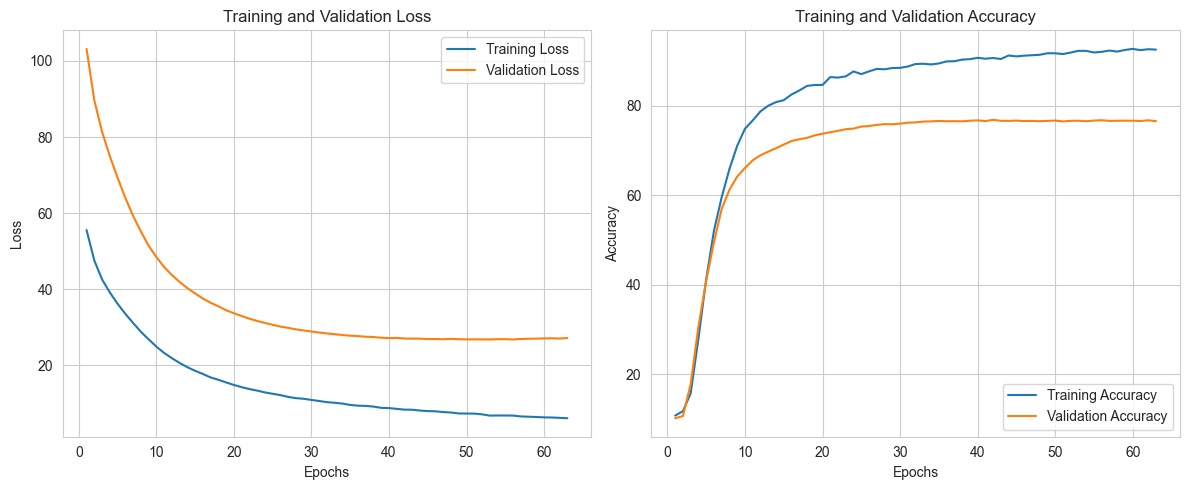

In [129]:
epochs = 100

def training():
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_acc = 0.0
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(ensemble, device, train_loader_noisy_10, criterion, optimizer, epoch)
        scheduler.step(train_loss)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        test_loss, test_acc = test(ensemble, device, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Terminate training if loss stopped to decrease
        if early_stopping(test_loss):
            print('\nEarly stopping\n')
            break
        # Deep copy the weight of model if its accuracy is the best for now
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(ensemble.state_dict())
            
        print(f"Training accuracy {train_acc}, test accuracy {test_acc}")
        print(f"Training loss {train_loss}, test loss {test_loss}")

    ensemble.load_state_dict(best_model_wts)
    torch.save(ensemble.state_dict(), "best_ensemble_model.pt")

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epoch + 1), test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epoch + 1), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


training()

## Comparing the models

In [4]:
def calculate_model_size(model):
    """
    Source: https://stackoverflow.com/questions/71851474/how-to-find-the-size-of-a-deep-learning-model
    :param model: model
    :return: size of the model in MB
    """
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024 ** 2
    return size_all_mb

In [5]:
def calculate_metrics(model, device, test_loader, drcn=False):
    """
    This function calculates roc_auc_score of the model and its inference speed
    :param model: given model
    :param device: given device
    :param test_loader: loader with data
    :return: roc_auc_score, inference time
    """
    model.eval()
    all_preds = []
    all_targets = []
    total_time = 0
    num_samples = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            start_time = time()
            if drcn:
                _, output = model(data)
            else:
                output = model(data)
            end_time = time()
            total_time += end_time - start_time
            num_samples += len(data)
            # Calculate predicted probabilities
            preds = output.argmax(dim=1, keepdim=True)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(target.cpu().numpy())

    inference_speed = round(num_samples / total_time)  # Images per second
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    accuracy = round(accuracy_score(all_targets, all_preds)*100, 2)
    model_size = round(calculate_model_size(model), 2)
    return [accuracy, inference_speed, model_size]

### Calculating metrics for all models

In [132]:
baseline_model_metrics = calculate_metrics(baselinde_model, device, test_loader)
baseline_model_metrics.append(50000)
baseline_model_metrics.append(0)
self_supevised_model_metrcis = calculate_metrics(self_supervised_model, device, test_loader)
self_supevised_model_metrcis.append(5000)
self_supevised_model_metrcis.append(50000)
drcn_metrcis = calculate_metrics(drcn_model, device, test_loader, drcn=True)
drcn_metrcis.append(5000)
drcn_metrcis.append(5000)
ensemble_metrcis = calculate_metrics(ensemble, device, test_loader)
ensemble_metrcis.append(5000)
ensemble_metrcis.append(0)

data=[baseline_model_metrics, self_supevised_model_metrcis, drcn_metrcis, ensemble_metrcis]
columns = ['Accuracy (%)', 'Inference speed (images/second)', 'Model size (MB)', 'Used number of labeled data', 'Used number of unlabeled data']
df = pd.DataFrame(data, columns=columns)

new_indexes = ['Base line model', 'Self-supervised model', 'DRCN model', 'Ensemble model']
df.index = new_indexes
df

,Accuracy (%),Inference speed (images/second),Model size (MB),Used number of labeled data,Used number of unlabeled data
Base line model,85.31,125864,7.51,50000,0
Self-supervised model,43.67,205464,2.10,5000,50000
DRCN model,58.65,128724,10.07,5000,5000
Ensemble model,76.82,46301,19.71,5000,0


| Model                 | Accuracy (%) | Inference speed (images/second) | Model size (MB) | Used number of labeled data | Used number of unlabeled data |
|-----------------------|--------------|----------------------------------|------------------|-----------------------------|-------------------------------|
| Base line model       | 85.31        | 125,864                          | 7.51             | 50,000                      | 0                             |
| Self-supervised model | 43.67        | 205,464                          | 2.10             | 5,000                       | 50,000                        |
| DRCN model            | 58.65        | 128,724                          | 10.07            | 5,000                       | 5,000                         |
| Ensemble model        | 76.82        | 46,301                           | 19.71            | 5,000                       | 0                             |


### Efficiency Analysis:

- **Accuracy**: The baseline model outperforms the other individual models in terms of accuracy, achieving an accuracy of 85.31%. The ensemble model, which combines the predictions of multiple models, achieves the second-highest accuracy of 76.82%. The self-supervised and DRCN models have lower accuracies of 43.67% and 58.65%, respectively.
- **Inference Speed**: The self-supervised model demonstrates the highest inference speed, processing approximately 205,464 images per second. This is due to its smaller model size and simpler architecture. The ensemble model has the slowest inference speed, because it combines the predictions of multiple models, resulting in more complex computations.
- **Model Size**: The self-supervised model has the smallest model size of 2.10 MB, followed by the baseline model at 7.51 MB. The DRCN model has a larger size of 10.07 MB, due to its more complex architecture. The ensemble model, which combines multiple models, has the largest size of 19.71 MB.
- **Labeled and Unlabeled Data**: The baseline model and ensemble model use only labeled data for training, while the self-supervised and DRCN models incorporate unlabeled data as well. This contributes to the performance differences, with models trained on more data generally performing better. However, the self-supervised model, despite using more unlabeled data, has the lowest accuracy, indicating that the quality of labeled data and model architecture also play significant roles.

In summary, while techniques like self-supervised learning and ensemble methods offer benefits such as reduced model size and improved accuracy, their effectiveness depends on various factors such as the quality and quantity of labeled and unlabeled data, model architecture, and computational efficiency.